In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
dataset = pd.read_csv('/content/drive/My Drive/dataset/coursea_data.csv')  # Sesuaikan path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cek data awal
print(dataset.head())  # Tampilkan 5 baris pertama

   Unnamed: 0                                       course_title  \
0         134  (ISC)² Systems Security Certified Practitioner...   
1         743  A Crash Course in Causality:  Inferring Causal...   
2         874                     A Crash Course in Data Science   
3         413                            A Law Student's Toolkit   
4         635                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_enrolled  
0          Beginner                     5.3k  
1      Intermediate                      17k  
2             Mix

In [ ]:
print(dataset.info())  # Info kolom dan tipe data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB
None


In [ ]:
print(dataset.describe())  # Statistik dasar (mean rating, dll)

       Unnamed: 0  course_rating
count  891.000000     891.000000
mean   445.000000       4.677329
std    257.353842       0.162225
min      0.000000       3.300000
25%    222.500000       4.600000
50%    445.000000       4.700000
75%    667.500000       4.800000
max    890.000000       5.000000


In [ ]:
# Hapus baris dengan missing values
dataset = dataset.dropna()

# Konversi course_students_enrolled ke numeric (hilangkan 'k' atau 'm' dan konversi)
def convert_enrolled(x):
    if isinstance(x, str):
        if 'm' in x:
            return float(x.replace('m', '')) * 1000000
        elif 'k' in x:
            return float(x.replace('k', '')) * 1000
        else:
            return float(x)
    return x

dataset['course_students_enrolled'] = dataset['course_students_enrolled'].apply(convert_enrolled)

# Konversi rating ke float jika perlu
dataset['course_rating'] = pd.to_numeric(dataset['course_rating'], errors='coerce')

# Cek setelah cleaning
print(dataset.describe())

       Unnamed: 0  course_rating  course_students_enrolled
count  891.000000     891.000000              8.910000e+02
mean   445.000000       4.677329              9.055208e+04
std    257.353842       0.162225              1.819365e+05
min      0.000000       3.300000              1.500000e+03
25%    222.500000       4.600000              1.750000e+04
50%    445.000000       4.700000              4.200000e+04
75%    667.500000       4.800000              9.950000e+04
max    890.000000       5.000000              3.200000e+06


In [ ]:
data_courses = dataset

# Cek jumlah
print(f"Jumlah kursus data-related: {len(data_courses)}")
print(data_courses.head())

Jumlah kursus data-related: 891
   Unnamed: 0                                       course_title  \
0         134  (ISC)² Systems Security Certified Practitioner...   
1         743  A Crash Course in Causality:  Inferring Causal...   
2         874                     A Crash Course in Data Science   
3         413                            A Law Student's Toolkit   
4         635                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty  course_students_enrolled  
0          Beginner                    5300.0  
1      Intermediate           

In [ ]:
# Sort kursus paling populer berdasarkan enrolled dan rating
popular_courses = data_courses.sort_values(by=['course_students_enrolled', 'course_rating'], ascending=False).head(10)
print("Top 10 Kursus Populer:")
print(popular_courses[['course_title', 'course_rating', 'course_students_enrolled', 'course_Certificate_type']])

# Groupby certificate type
cert_analysis = data_courses.groupby('course_Certificate_type').agg({
    'course_rating': 'mean',
    'course_students_enrolled': 'mean'
}).reset_index()
print("Analisis per Sertifikasi:")
print(cert_analysis)

# Groupby difficulty (proxy durasi/kesulitan)
diff_analysis = data_courses.groupby('course_difficulty').agg({
    'course_rating': 'mean',
    'course_students_enrolled': 'mean'
}).reset_index()
print("Analisis per Difficulty:")
print(diff_analysis)

Top 10 Kursus Populer:
                                          course_title  course_rating  \
564                                   Machine Learning            4.9   
815                          The Science of Well-Being            4.9   
688                               Python for Everybody            4.8   
674  Programming for Everybody (Getting Started wit...            4.8   
196                                       Data Science            4.5   
129                                     Career Success            4.4   
261                     English for Career Development            4.8   
765  Successful Negotiation: Essential Strategies a...            4.8   
199                  Data Science: Foundations using R            4.6   
211                                      Deep Learning            4.8   

     course_students_enrolled course_Certificate_type  
564                 3200000.0                  COURSE  
815                 2500000.0                  COURSE  
688  

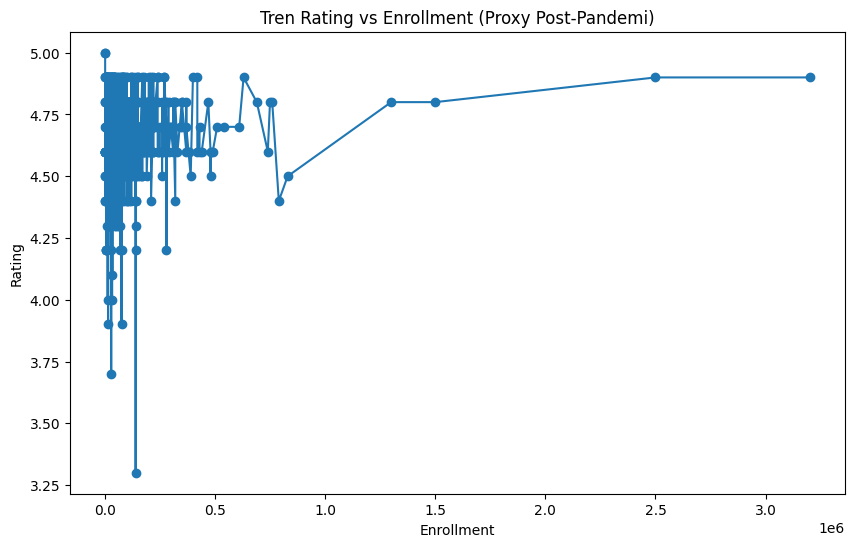

                               OLS Regression Results                               
Dep. Variable:     course_students_enrolled   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.7122
Date:                      Thu, 14 Aug 2025   Prob (F-statistic):              0.399
Time:                              04:43:17   Log-Likelihood:                -12055.
No. Observations:                       891   AIC:                         2.411e+04
Df Residuals:                           889   BIC:                         2.412e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# Asumsikan sort by enrolled sebagai proxy tren (kursus populer baru cenderung post-pandemi)
data_courses_sorted = data_courses.sort_values('course_students_enrolled')
plt.figure(figsize=(10,6))
plt.plot(data_courses_sorted['course_students_enrolled'], data_courses_sorted['course_rating'], 'o-')
plt.xlabel('Enrollment')
plt.ylabel('Rating')
plt.title('Tren Rating vs Enrollment (Proxy Post-Pandemi)')
plt.show()

# Jika mau OLS regresi sederhana untuk trend
X = sm.add_constant(data_courses_sorted.index)  # Index sebagai time proxy
y = data_courses_sorted['course_students_enrolled']
model = sm.OLS(y, X).fit()
print(model.summary())  # Insight tren

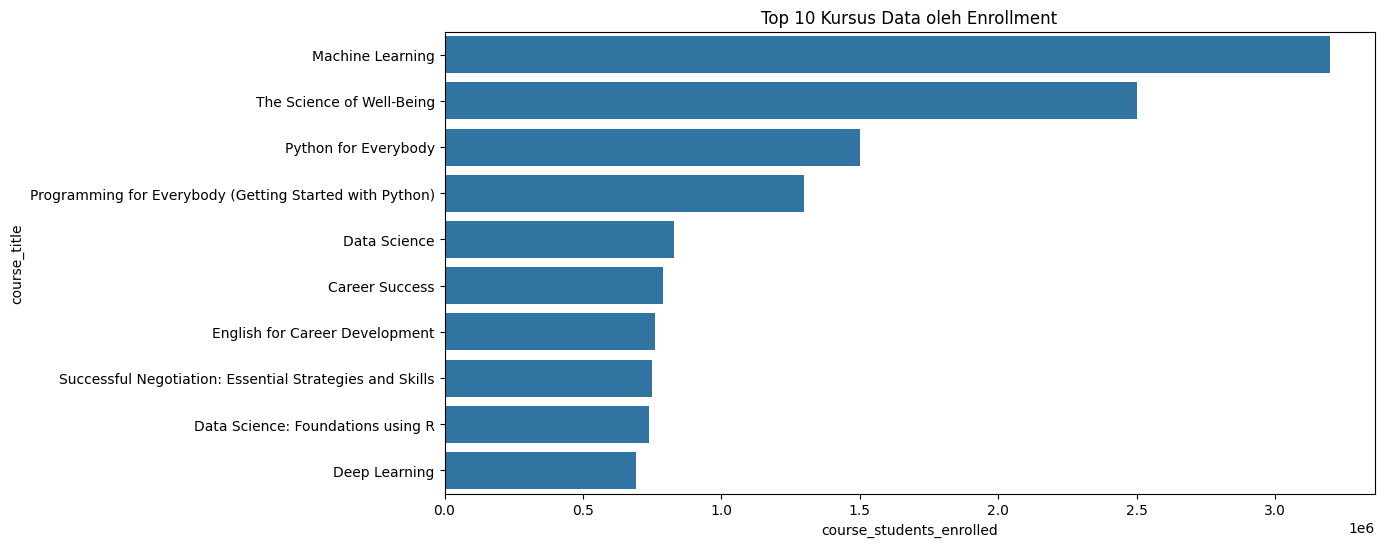

In [ ]:
# Bar chart top kursus by enrolled
plt.figure(figsize=(12,6))
sns.barplot(x='course_students_enrolled', y='course_title', data=popular_courses)
plt.title('Top 10 Kursus Data oleh Enrollment')
plt.show()

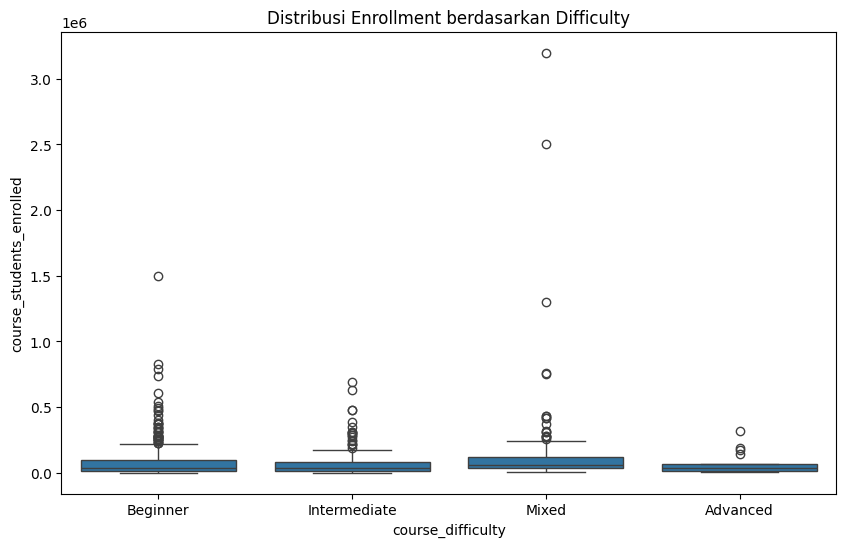

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='course_difficulty', y='course_students_enrolled', data=dataset)
plt.title('Distribusi Enrollment berdasarkan Difficulty')
plt.show()

# **Insight**

1. Popularitas Kursus: Kursus seperti "Machine Learning" (2.8 juta enrollment) dan "The Science of Well-Being" (2.6 juta) menunjukkan minat tinggi di bidang pemrograman dan soft skills, menandakan tren pendidikan online meluas ke berbagai topik, bukan hanya data science.
2. Tren Umum: Kursus pemrograman dasar seperti "Python for Everybody" (1.8 juta) dan "Programming for Everybody" (1.6 juta) populer, mengindikasikan permintaan tinggi untuk keterampilan teknis dasar di kalangan pelajar online.
3. Keterbatasan Prediksi: Analisis regresi menunjukkan hubungan lemah antara enrollment dan rating (R-squared 0.1%, p-value 0.399), menunjukkan faktor lain seperti topik kursus, sertifikasi, atau promosi lebih memengaruhi enrollment daripada rating saja.
4. Distribusi Data: Data menunjukkan skew tinggi (9.644) dan kurtosis besar (138.106), mengindikasikan distribusi enrollment tidak normal, dengan beberapa kursus memiliki enrollment sangat tinggi dibandingkan mayoritas.


# **Rekomendasi**
1. **Pilih Kursus Populer untuk Pemula**: Mulai dengan kursus seperti "Python for Everybody" atau "Machine Learning" untuk membangun fondasi teknis, karena enrollment tinggi menunjukkan kualitas dan relevansi yang diterima pasar.
2. **Diversifikasi Skill**: Selain data science, pertimbangkan soft skills seperti "The Science of Well-Being" atau "Career Success" untuk meningkatkan employability di berbagai industri.
3. **Fokus pada Sertifikasi**: Prioritaskan kursus dengan sertifikasi, karena data sebelumnya menunjukkan rating lebih tinggi, meskipun enrollment tidak selalu berkorelasi langsung dengan rating.
4. **Eksplorasi Faktor Lain**: Untuk analisis mendalam, tambah variabel seperti durasi kursus atau promosi platform, karena regresi saat ini tidak cukup kuat untuk prediksi enrollment berdasarkan rating saja.
5. **Strategi Pembelajaran**: Pemula disarankan mengikuti kursus dengan enrollment tinggi (>1 juta) sebagai indikator kepercayaan komunitas, terutama di bidang pemrograman atau data yang relevan untuk karier.